## << 문제 정의 >>

글로벌 쇼핑몰의 클릭 로그 데이터를 분석하여, 어떤 유저가 어떤 아이템을 클릭하는지 확인하고 싶습니다.
주어진 데이터는 해당 쇼핑몰의 2024년 4월 1일부터 2024년 5월 7일까지의 클릭 로그 데이터입니다.

2024년 4월 1일부터 4월 30일까지의 데이터를 학습하여, 그 이후 일주일간 각 아이템을 클릭하는지 안하는지를 예측하는 문제를 풀어보세요.

자세한 대회 관련 사항은 아래 대회 페이지를 참조하세요.

[Competition Page]

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import warnings
import xgboost as xgb
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

seed_everything(42)  # 무조건 42로 세팅!!

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
train.shape, test.shape, submission.shape

((48199, 13), (7695, 12), (7695, 2))

In [ ]:
train.isnull().sum()

,0
click_id,0
date,0
order,0
country,0
session ID,0
page 1 (main category),31
page 2 (clothing model),2135
colour,0
location,0
model photography,0


In [ ]:
train['page 1 (main category)'] = train['page 1 (main category)'].fillna(train['page 1 (main category)'].mode().values[0])
train['page 2 (clothing model)'] = train['page 2 (clothing model)'].fillna(train['page 2 (clothing model)'].mode().values[0])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48199 entries, 0 to 48198
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   click_id                 48199 non-null  int64  
 1   date                     48199 non-null  object 
 2   order                    48199 non-null  int64  
 3   country                  48199 non-null  int64  
 4   session ID               48199 non-null  int64  
 5   page 1 (main category)   48199 non-null  float64
 6   page 2 (clothing model)  48199 non-null  object 
 7   colour                   48199 non-null  int64  
 8   location                 48199 non-null  int64  
 9   model photography        48199 non-null  int64  
 10  page                     48199 non-null  int64  
 11  price                    48199 non-null  float64
 12  Clicked                  48199 non-null  int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 4.8+ MB


In [ ]:
# [기본]
train['page 2 (clothing model)'] = pd.factorize(train['page 2 (clothing model)'])[0]
# [one-hot]
#train = pd.get_dummies(train, columns=['page 2 (clothing model)'])
train

,click_id,date,order,country,session ID,page 1 (main category),page 2 (clothing model),colour,location,model photography,page,price,Clicked
0,1,2024-04-01,1,29,1,1.0,0,1,5,1,1,39.0,1
1,2,2024-04-01,2,29,1,1.0,1,1,6,1,1,40.0,0
2,3,2024-04-01,3,29,1,2.0,2,10,2,1,1,46.0,1
3,4,2024-04-01,4,29,1,2.0,3,6,6,2,1,30.0,0
4,5,2024-04-01,5,29,1,2.0,4,4,3,2,1,41.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48194,48195,2024-04-30,38,29,6940,2.0,58,6,5,2,2,39.0,0
48195,48196,2024-04-30,39,29,6940,2.0,59,2,6,1,2,46.0,0
48196,48197,2024-04-30,40,29,6940,4.0,103,4,2,1,1,49.0,1
48197,48198,2024-04-30,41,29,6940,4.0,200,12,1,2,5,49.0,0


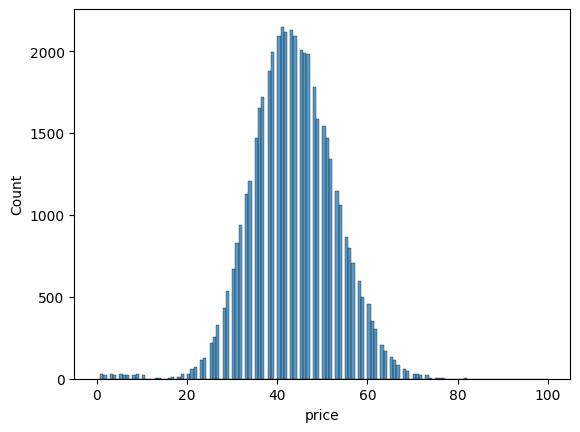

In [ ]:
sns.histplot(train['price'], binrange = (0, 100))
train = train[train['price'] >= 20]

In [ ]:
# feature vector
X = train.drop(columns=['click_id', 'date', 'order', 'country', 'session ID', 'Clicked'])
# target value
y = train.Clicked

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(38312, 7) (9579, 7) (38312,) (9579,)


In [ ]:
# 예측에 사용할 모델을 가져와서 학습
clf = xgb.XGBClassifier(colsample_bytree = 0.2,
                       learning_rate = 0.15,
                       max_depth =  1,
                       objective = 'binary:logistic',
                       min_child_weight =  5,
                       n_estimators = 300,
                       gamma = 1,
                       subsample = 0.8,
                       scale_pos_weight = 1)

                      #max_depth = 1,
                      #objective = 'binary:logistic',
                      #n_estimators = 300,
                      #max_features = 0.5,
                      #learning_rate = 0.3,
                      #random_state = 42

clf.fit(X_train, y_train)

# 학습한 모델을 평가
from sklearn.metrics import accuracy_score

train_pred = clf.predict(X_train)
val_pred = clf.predict(X_val)

print("Train ACC : %.4f" % accuracy_score(y_train, train_pred))
print("Val ACC : %.4f" % accuracy_score(y_val, val_pred))

Train ACC : 0.6719
Val ACC : 0.6759


In [ ]:
# X_test를 만들어서 아래 코드를 실행하세요.
X_test = test.drop(columns=['click_id', 'date', 'order', 'country', 'session ID'])
X_test['page 2 (clothing model)'] = pd.factorize(X_test['page 2 (clothing model)'])[0]
# [one-hot]
# test = pd.get_dummies(test, columns=['page 2 (clothing model)'])
# X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

output = clf.predict(X_test)
assert len(output) == 7695  # sanity check

In [ ]:
# submission DataFrame을 만들어서 아래 코드를 실행하세요.
submission = pd.read_csv('sample_submission.csv')
submission['Clicked'] = output
submission.to_csv('submission.csv', index=False)